In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBClassifier

In [3]:
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks
# from imblearn.over_sampling import RandomOverSampler

In [3]:
import time
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [49]:
import shap

In [4]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

### Getting Data

In [5]:
res = pd.read_csv('../Outputs/resampled.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [6]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1] 
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [33]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 10, 500),
        'learning_rate':trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth':trial.suggest_int('max_depth', 3, 10),
        'gamma':trial.suggest_float('gamma', 0, 3),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0, 1),
        'eval_metric':trial.suggest_categorical('eval_metric', ['auc', 'aucpr'])
    }
    
    xgb_model = XGBClassifier(**params, objective='binary:logistic', random_state=42)
    xgb_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = xgb_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [34]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=100)

[I 2024-06-05 18:39:04,337] A new study created in memory with name: no-name-d48bdc29-c07a-4f1a-8316-74207961438c
[I 2024-06-05 18:39:14,526] Trial 0 finished with value: 0.5887061510467473 and parameters: {'n_estimators': 404, 'learning_rate': 0.07730865016199719, 'max_depth': 10, 'gamma': 2.4495310904169387, 'colsample_bytree': 0.12508792080676256, 'eval_metric': 'aucpr'}. Best is trial 0 with value: 0.5887061510467473.
[I 2024-06-05 18:39:18,632] Trial 1 finished with value: 0.5884205935319277 and parameters: {'n_estimators': 250, 'learning_rate': 0.15284693064741622, 'max_depth': 8, 'gamma': 2.150270549535182, 'colsample_bytree': 0.2852346428867999, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.5887061510467473.
[I 2024-06-05 18:39:20,600] Trial 2 finished with value: 0.5994838954753507 and parameters: {'n_estimators': 138, 'learning_rate': 0.19219407086664114, 'max_depth': 8, 'gamma': 1.661973307262886, 'colsample_bytree': 0.0003481092063066793, 'eval_metric': 'auc'}. Best 

In [35]:
xgb_model = XGBClassifier(**study.best_params, objective='binary:logistic', 
                          random_state=42)
xgb_model.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.019724888108870388, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=1.9670956848723988,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05845673648874195,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Making Predictions

In [36]:
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

### Ploting and Metrics

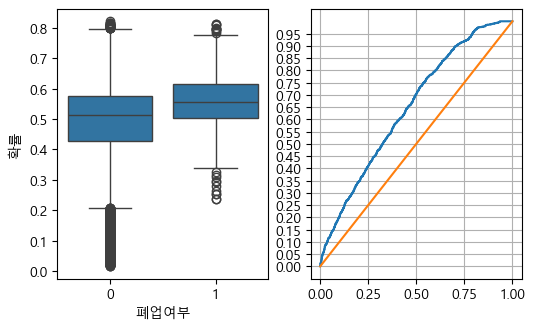

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5))

temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp, ax=ax[0])
plt.yticks(np.arange(0, 1, 0.05))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = 'ROC')
plt.plot([0, 1], [0, 1])
ax[1].grid()

plt.show()

In [42]:
threshold = 0.52
y_pred = (y_pred_prob >= threshold).astype('int')

In [79]:
print("0-1 proportion at test set :", y_test.value_counts().values)
print("accuracy score :", accuracy_score(y_test, y_pred))
print("precision score :", precision_score(y_test, y_pred))
print("sensitivitiy :", cm[0][0]/(cm[0][0]+cm[0][1]))
print("recall score :", recall_score(y_test, y_pred))
print("average accuracy :", np.mean([cm[0][0]/(cm[0][0]+cm[0][1]), recall_score(y_test, y_pred)]))
print("f1_score :", f1_score(y_test, y_pred))
print("AUC score :", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308   800]
accuracy score : 0.5234530938123753
sensitivitiy : 0.5212538455766489
recall score : 0.67
average accuracy : 0.5956269227883244
AUC score : 0.5956269227883244


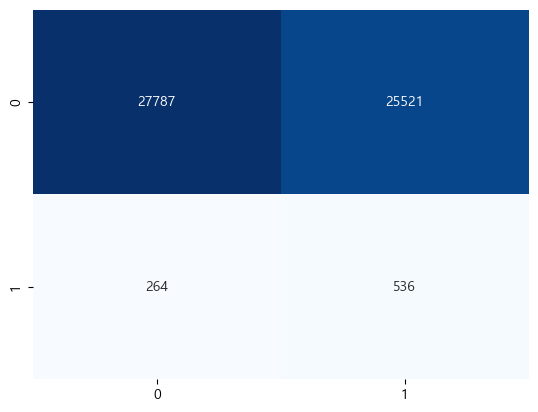

In [47]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')
plt.show()

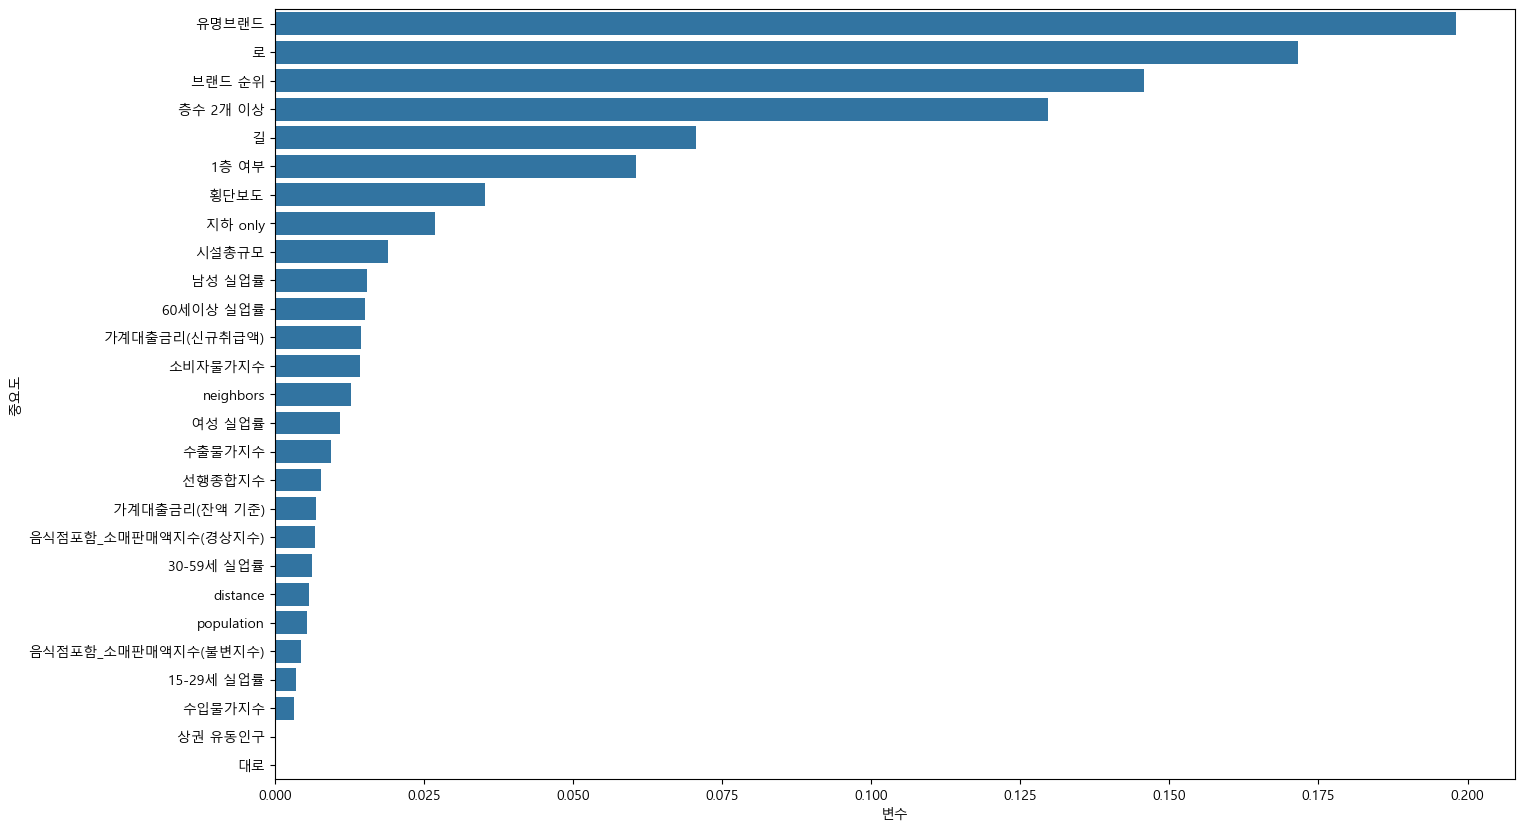

In [48]:
## Feature Importance
ser = pd.Series(xgb_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.xlabel('변수')
plt.ylabel('중요도')
plt.show()

### Using `SHAP`

In [50]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_res)

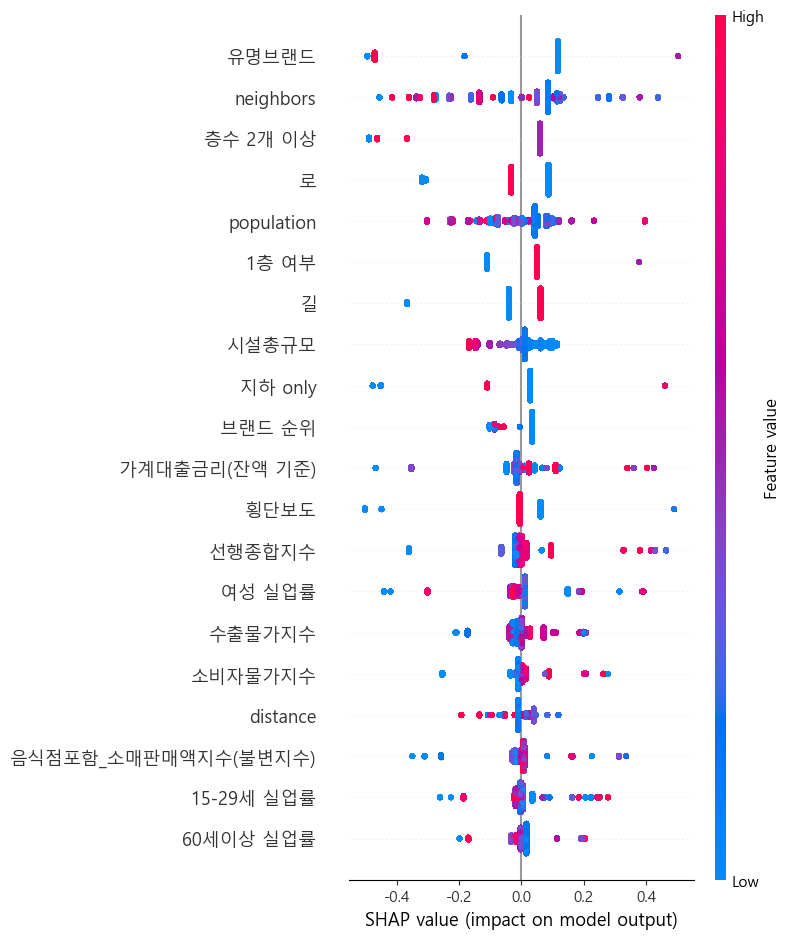

In [63]:
plt.rcParams['axes.unicode_minus'] = False
shap.summary_plot(shap_values, X_res)
plt.show()